In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/Clustering/Pokemon
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/Clustering/Pokemon
images/  pokemon.csv


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [ ]:
# Initialize ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Function to preprocess and extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

# Path to the folder containing images
image_folder_path = 'images'

# Extract features for each image
features = []
for img_name in os.listdir(image_folder_path):
    img_path = os.path.join(image_folder_path, img_name)
    img_features = extract_features(img_path, model)
    features.append(img_features)

In [ ]:
# Convert to a matrix for clustering
features_matrix = np.array(features)

# Apply clustering algorithm (e.g., K-Means)
kmeans = KMeans(n_clusters=10, random_state=22)  # Adjust number of clusters as needed
cluster_labels = kmeans.fit_predict(features_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


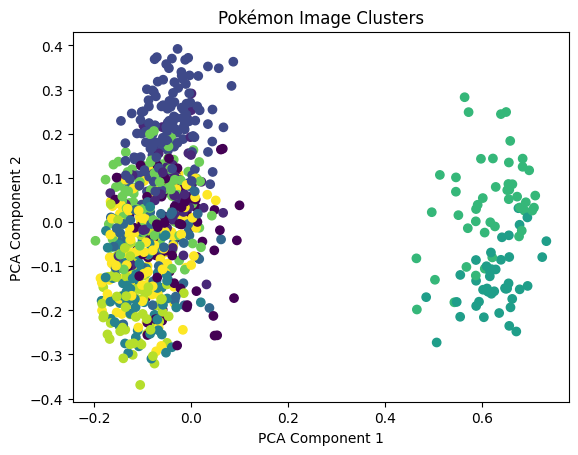

In [ ]:
# Load CSV data
pokemon_df = pd.read_csv('pokemon.csv')

# Add cluster labels to the dataframe
pokemon_df['cluster'] = cluster_labels

# Optionally, perform PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_matrix)

# Plotting (if needed)
import matplotlib.pyplot as plt

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Pokémon Image Clusters')
plt.show()

# Save the clustered data
pokemon_df.to_csv('output_clusters.csv', index=False)

In [ ]:
pokemon_df.head()

,Name,Type1,Type2,cluster
0,bulbasaur,Grass,Poison,0
1,ivysaur,Grass,Poison,2
2,venusaur,Grass,Poison,7
3,charmander,Fire,NaN,0
4,charmeleon,Fire,NaN,9


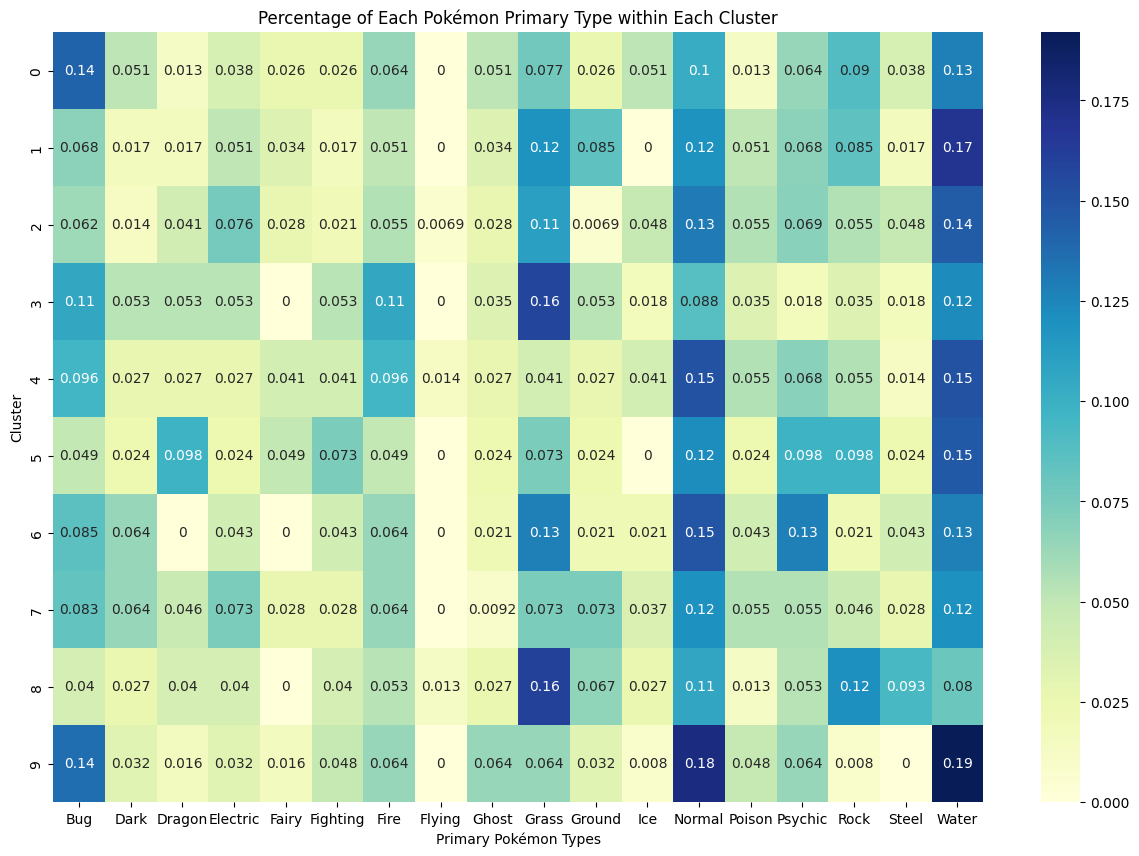

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'primary_type' is the column for Pokémon primary types
# Calculate the percentage of each primary type within each cluster
type_cluster_percentage = (pokemon_df.groupby(['cluster', 'Type1']).size() /
                           pokemon_df.groupby('cluster').size()).reset_index(name='percentage')

# Pivot for easier plotting
pivot_table = type_cluster_percentage.pivot(index='cluster', columns='Type1', values='percentage').fillna(0)

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title('Percentage of Each Pokémon Primary Type within Each Cluster')
plt.ylabel('Cluster')
plt.xlabel('Primary Pokémon Types')
plt.show()